In [1]:
import os
import time
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
# ensure directory structure includes 'nitorch' from https://github.com/moboehle/Pytorch-LRP/tree/master/nitorch,
# as there are other packages named 'nitorch' that will not work here
from nitorch import callbacks, trainer, inference, metrics
from nitorch import transforms as nitransform
from nitorch.metrics import balanced_accuracy
from nitorch.callbacks import ModelCheckpoint, EarlyStopping

# Read in data
## Ensure that file paths match your directory structure

In [2]:
img_dir = ('C:/Users/Ben/Desktop/MRI_Mask/MRI_FSCS/') # change this to directory with MRI images     
img_files = sorted(os.listdir(img_dir))


# read in CSV description of downloaded MRI scans
df = pd.read_csv('C:/Users/Ben/Desktop/MRI_Mask/MRI_FSCS_4_20_2021.csv')

# create x and y arrays
group = []
for i in range(len(img_files)):
    idx = img_files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0]) 
group = ((np.array(group) == 'AD') / 1)

tmp = np.arange(len(img_files))
train, temp = train_test_split(tmp, test_size=.2, shuffle = True, stratify = group, random_state = 12)
val, test = train_test_split(temp, test_size=.5, shuffle = True, stratify = group[temp], random_state = 42)
x_train = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[train]])
y_train = group[train]
x_val = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[val]])
y_val = group[val]
x_test = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[test]])
y_test = group[test]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(sum(y_train))
print(sum(y_val))
print(y_test.shape)
print(sum(y_test))

(338, 256, 10, 256, 1)
(42, 256, 10, 256, 1)
(338,)
(42,)
157.0
19.0
(43,)
20.0


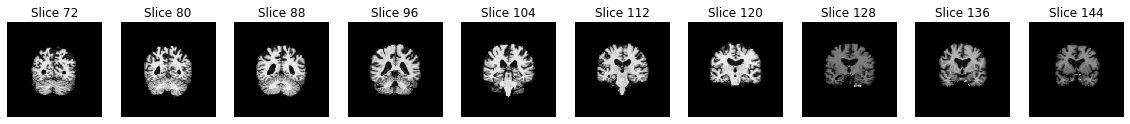

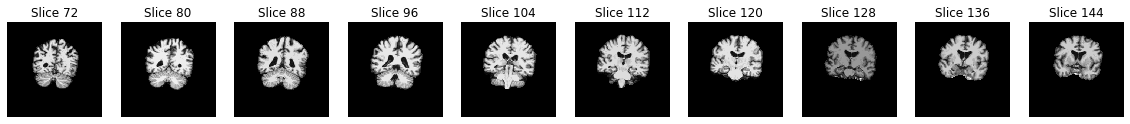

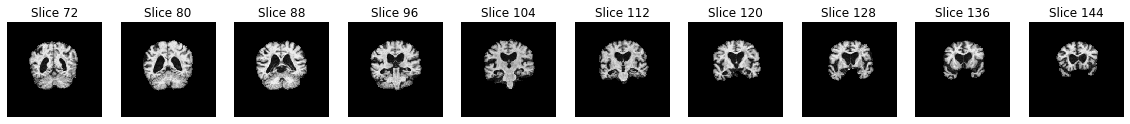

In [3]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i, :].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

show_slices(x_train[0,:,:,:,0])
show_slices(x_train[50,:,:,:,0])
show_slices(x_train[200,:,:,:,0])

# Build an ensemble based on specified slices
## Make to specify a directory to save the sub-models in the `model_path` field

In [10]:
def crop(x, z_slice=0, dims=(200, 200)):
    x = np.moveaxis(x, 2, 3)
    x = np.moveaxis(x[:,:,:,z_slice], -1, 1)
    x_new = np.zeros((x.shape[0], x.shape[1], dims[0], dims[1]))
    for i in range(len(x)):
        data = np.argwhere(x[i][0])
        min_idx = np.min(data, axis=0)
        max_idx = np.max(data, axis=0)
        crop = x[i][0][min_idx[0]:max_idx[0], min_idx[1]:max_idx[1]]
        left_right = int((dims[0]-crop.shape[0])/2)
        bottom_top = int((dims[1]-crop.shape[1])/2)
        x_new[i][0] = np.pad(crop, ((left_right, dims[0]-crop.shape[0]-left_right), (dims[1]-crop.shape[1]-bottom_top, bottom_top)))
        
    return x_new

def min_max(x):
    for i in range(len(x)):
        x[i] -= np.min(x[i])
        x[i] /= np.max(x[i])
    
    return x

Starting slice 0
(338, 1, 200, 200)
(42, 1, 200, 200)
C:/Users/Ben/Desktop/MRI_Mask/torch_10.1
Starting trial 0


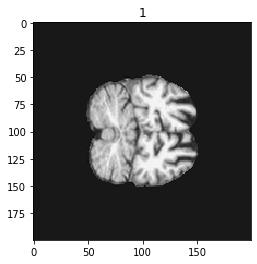

[0,    60] loss: 0.71808
Time elapsed: 0h:0m:6s
train accuracy_score: 52.96 %
val accuracy_score: 45.24 %
Val loss: 0.710400
[1,    60] loss: 0.69834
Time elapsed: 0h:0m:13s
train accuracy_score: 55.03 %
val accuracy_score: 57.14 %
Val loss: 0.682502
[2,    60] loss: 0.68680
Time elapsed: 0h:0m:20s
train accuracy_score: 58.58 %
val accuracy_score: 52.38 %
Val loss: 0.692765
[3,    60] loss: 0.70585
Time elapsed: 0h:0m:29s
train accuracy_score: 56.80 %
val accuracy_score: 54.76 %
Val loss: 0.693116
[4,    60] loss: 0.69481
Time elapsed: 0h:0m:37s
train accuracy_score: 54.44 %
val accuracy_score: 54.76 %
Val loss: 0.722737
[5,    60] loss: 0.64452
Time elapsed: 0h:0m:46s
train accuracy_score: 59.47 %
val accuracy_score: 59.52 %
Val loss: 0.693452
[6,    60] loss: 0.64352
Time elapsed: 0h:0m:55s
train accuracy_score: 62.13 %
val accuracy_score: 42.86 %
Val loss: 0.748730
[7,    60] loss: 0.65226
Time elapsed: 0h:1m:4s
train accuracy_score: 56.51 %
val accuracy_score: 52.38 %
Val loss: 0.7

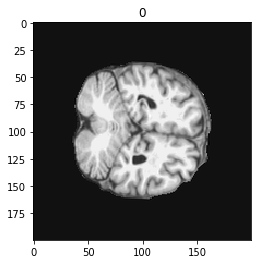

[0,    60] loss: 0.74324
Time elapsed: 0h:0m:8s
train accuracy_score: 51.48 %
val accuracy_score: 54.76 %
Val loss: 0.701586
[1,    60] loss: 0.74491
Time elapsed: 0h:0m:17s
train accuracy_score: 54.14 %
val accuracy_score: 50.00 %
Val loss: 0.697824
[2,    60] loss: 0.70180
Time elapsed: 0h:0m:26s
train accuracy_score: 55.33 %
val accuracy_score: 54.76 %
Val loss: 0.713031
[3,    60] loss: 0.65135
Time elapsed: 0h:0m:34s
train accuracy_score: 60.65 %
val accuracy_score: 40.48 %
Val loss: 0.726557
[4,    60] loss: 0.68013
Time elapsed: 0h:0m:43s
train accuracy_score: 59.17 %
val accuracy_score: 59.52 %
Val loss: 0.708454
[5,    60] loss: 0.67107
Time elapsed: 0h:0m:51s
train accuracy_score: 56.21 %
val accuracy_score: 45.24 %
Val loss: 0.768447
[6,    60] loss: 0.66728
Time elapsed: 0h:1m:0s
train accuracy_score: 60.65 %
val accuracy_score: 52.38 %
Val loss: 0.722202
[7,    60] loss: 0.63141
Time elapsed: 0h:1m:9s
train accuracy_score: 62.72 %
val accuracy_score: 50.00 %
Val loss: 0.72

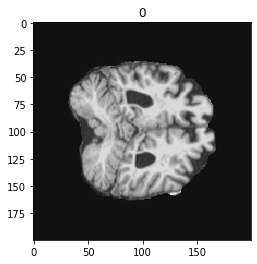

[0,    60] loss: 0.73755
Time elapsed: 0h:0m:8s
train accuracy_score: 54.14 %
val accuracy_score: 54.76 %
Val loss: 0.724829
[1,    60] loss: 0.73131
Time elapsed: 0h:0m:16s
train accuracy_score: 52.37 %
val accuracy_score: 52.38 %
Val loss: 0.690133
[2,    60] loss: 0.67187
Time elapsed: 0h:0m:24s
train accuracy_score: 56.21 %
val accuracy_score: 59.52 %
Val loss: 0.686465
[3,    60] loss: 0.68080
Time elapsed: 0h:0m:32s
train accuracy_score: 56.21 %
val accuracy_score: 57.14 %
Val loss: 0.683157
[4,    60] loss: 0.66395
Time elapsed: 0h:0m:40s
train accuracy_score: 58.58 %
val accuracy_score: 54.76 %
Val loss: 0.696449
[5,    60] loss: 0.66415
Time elapsed: 0h:0m:48s
train accuracy_score: 60.36 %
val accuracy_score: 52.38 %
Val loss: 0.711009
[6,    60] loss: 0.67592
Time elapsed: 0h:0m:57s
train accuracy_score: 58.88 %
val accuracy_score: 57.14 %
Val loss: 0.689059
[7,    60] loss: 0.63870
Time elapsed: 0h:1m:6s
train accuracy_score: 61.24 %
val accuracy_score: 59.52 %
Val loss: 0.7

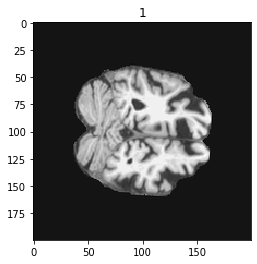

[0,    60] loss: 0.71879
Time elapsed: 0h:0m:7s
train accuracy_score: 51.78 %
val accuracy_score: 45.24 %
Val loss: 0.771724
[1,    60] loss: 0.69185
Time elapsed: 0h:0m:15s
train accuracy_score: 56.51 %
val accuracy_score: 52.38 %
Val loss: 0.690481
[2,    60] loss: 0.68818
Time elapsed: 0h:0m:23s
train accuracy_score: 55.92 %
val accuracy_score: 50.00 %
Val loss: 0.708678
[3,    60] loss: 0.68955
Time elapsed: 0h:0m:32s
train accuracy_score: 58.88 %
val accuracy_score: 52.38 %
Val loss: 0.697707
[4,    60] loss: 0.65854
Time elapsed: 0h:0m:40s
train accuracy_score: 60.36 %
val accuracy_score: 59.52 %
Val loss: 0.699163
[5,    60] loss: 0.66282
Time elapsed: 0h:0m:48s
train accuracy_score: 60.36 %
val accuracy_score: 54.76 %
Val loss: 0.711440
[6,    60] loss: 0.65076
Time elapsed: 0h:0m:56s
train accuracy_score: 63.91 %
val accuracy_score: 42.86 %
Val loss: 0.746796
[7,    60] loss: 0.62627
Time elapsed: 0h:1m:4s
train accuracy_score: 65.68 %
val accuracy_score: 54.76 %
Val loss: 0.6

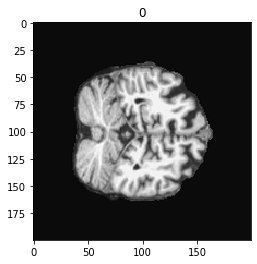

[0,    60] loss: 0.79884
Time elapsed: 0h:0m:7s
train accuracy_score: 47.63 %
val accuracy_score: 35.71 %
Val loss: 0.730439
[1,    60] loss: 0.70129
Time elapsed: 0h:0m:14s
train accuracy_score: 55.62 %
val accuracy_score: 54.76 %
Val loss: 0.727610
[2,    60] loss: 0.69574
Time elapsed: 0h:0m:22s
train accuracy_score: 52.96 %
val accuracy_score: 54.76 %
Val loss: 0.718012
[3,    60] loss: 0.71971
Time elapsed: 0h:0m:30s
train accuracy_score: 51.78 %
val accuracy_score: 40.48 %
Val loss: 0.718214
[4,    60] loss: 0.71537
Time elapsed: 0h:0m:38s
train accuracy_score: 53.55 %
val accuracy_score: 45.24 %
Val loss: 0.721546
[5,    60] loss: 0.63661
Time elapsed: 0h:0m:46s
train accuracy_score: 64.50 %
val accuracy_score: 42.86 %
Val loss: 0.784325
[6,    60] loss: 0.66199
Time elapsed: 0h:0m:54s
train accuracy_score: 63.02 %
val accuracy_score: 50.00 %
Val loss: 0.721366
[7,    60] loss: 0.64618
Time elapsed: 0h:1m:2s
train accuracy_score: 61.24 %
val accuracy_score: 54.76 %
Val loss: 0.7

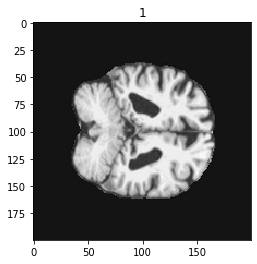

[0,    60] loss: 0.79677
Time elapsed: 0h:0m:7s
train accuracy_score: 46.45 %
val accuracy_score: 57.14 %
Val loss: 0.688720
[1,    60] loss: 0.73465
Time elapsed: 0h:0m:15s
train accuracy_score: 47.93 %
val accuracy_score: 40.48 %
Val loss: 0.714338
[2,    60] loss: 0.67378
Time elapsed: 0h:0m:22s
train accuracy_score: 58.88 %
val accuracy_score: 45.24 %
Val loss: 0.689865
[3,    60] loss: 0.70123
Time elapsed: 0h:0m:30s
train accuracy_score: 52.37 %
val accuracy_score: 54.76 %
Val loss: 0.721934
[4,    60] loss: 0.65534
Time elapsed: 0h:0m:38s
train accuracy_score: 60.06 %
val accuracy_score: 47.62 %
Val loss: 0.708371
[5,    60] loss: 0.67967
Time elapsed: 0h:0m:46s
train accuracy_score: 58.28 %
val accuracy_score: 57.14 %
Val loss: 0.705966
[6,    60] loss: 0.68156
Time elapsed: 0h:0m:53s
train accuracy_score: 60.65 %
val accuracy_score: 52.38 %
Val loss: 0.706820
[7,    60] loss: 0.65886
Time elapsed: 0h:1m:1s
train accuracy_score: 61.54 %
val accuracy_score: 54.76 %
Val loss: 0.6

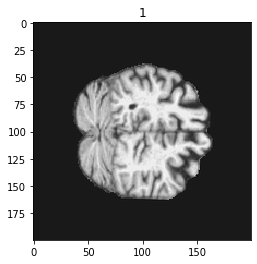

[0,    60] loss: 0.77595
Time elapsed: 0h:0m:7s
train accuracy_score: 52.66 %
val accuracy_score: 54.76 %
Val loss: 0.688402
[1,    60] loss: 0.69221
Time elapsed: 0h:0m:14s
train accuracy_score: 59.47 %
val accuracy_score: 59.52 %
Val loss: 0.676904
[2,    60] loss: 0.67847
Time elapsed: 0h:0m:22s
train accuracy_score: 57.69 %
val accuracy_score: 54.76 %
Val loss: 0.686178
[3,    60] loss: 0.69807
Time elapsed: 0h:0m:30s
train accuracy_score: 56.21 %
val accuracy_score: 61.90 %
Val loss: 0.679737
[4,    60] loss: 0.65775
Time elapsed: 0h:0m:37s
train accuracy_score: 61.54 %
val accuracy_score: 59.52 %
Val loss: 0.678189
[5,    60] loss: 0.67532
Time elapsed: 0h:0m:45s
train accuracy_score: 57.40 %
val accuracy_score: 57.14 %
Val loss: 0.706529
[6,    60] loss: 0.64398
Time elapsed: 0h:0m:53s
train accuracy_score: 60.65 %
val accuracy_score: 54.76 %
Val loss: 0.683266
[7,    60] loss: 0.61614
Time elapsed: 0h:1m:1s
train accuracy_score: 64.20 %
val accuracy_score: 59.52 %
Val loss: 0.6

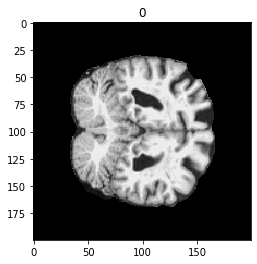

[0,    60] loss: 0.72557
Time elapsed: 0h:0m:7s
train accuracy_score: 50.30 %
val accuracy_score: 50.00 %
Val loss: 0.684092
[1,    60] loss: 0.71388
Time elapsed: 0h:0m:14s
train accuracy_score: 57.69 %
val accuracy_score: 54.76 %
Val loss: 0.707243
[2,    60] loss: 0.71660
Time elapsed: 0h:0m:22s
train accuracy_score: 53.25 %
val accuracy_score: 66.67 %
Val loss: 0.669783
[3,    60] loss: 0.65915
Time elapsed: 0h:0m:30s
train accuracy_score: 61.54 %
val accuracy_score: 61.90 %
Val loss: 0.672815
[4,    60] loss: 0.65899
Time elapsed: 0h:0m:37s
train accuracy_score: 60.06 %
val accuracy_score: 61.90 %
Val loss: 0.674371
[5,    60] loss: 0.64724
Time elapsed: 0h:0m:45s
train accuracy_score: 59.76 %
val accuracy_score: 54.76 %
Val loss: 0.718656
[6,    60] loss: 0.61420
Time elapsed: 0h:0m:53s
train accuracy_score: 64.79 %
val accuracy_score: 59.52 %
Val loss: 0.674441
[7,    60] loss: 0.63550
Time elapsed: 0h:1m:1s
train accuracy_score: 64.20 %
val accuracy_score: 54.76 %
Val loss: 0.7

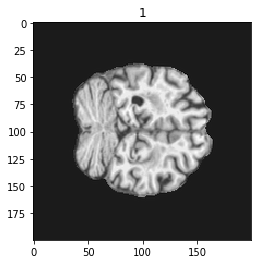

[0,    60] loss: 0.73259
Time elapsed: 0h:0m:7s
train accuracy_score: 49.41 %
val accuracy_score: 66.67 %
Val loss: 0.683360
[1,    60] loss: 0.68334
Time elapsed: 0h:0m:14s
train accuracy_score: 55.33 %
val accuracy_score: 54.76 %
Val loss: 0.683853
[2,    60] loss: 0.67317
Time elapsed: 0h:0m:22s
train accuracy_score: 59.17 %
val accuracy_score: 50.00 %
Val loss: 0.688179
[3,    60] loss: 0.65908
Time elapsed: 0h:0m:30s
train accuracy_score: 58.28 %
val accuracy_score: 50.00 %
Val loss: 0.699887
[4,    60] loss: 0.67493
Time elapsed: 0h:0m:38s
train accuracy_score: 57.40 %
val accuracy_score: 59.52 %
Val loss: 0.682939
[5,    60] loss: 0.65945
Time elapsed: 0h:0m:45s
train accuracy_score: 57.40 %
val accuracy_score: 45.24 %
Val loss: 0.771233
[6,    60] loss: 0.64312
Time elapsed: 0h:0m:53s
train accuracy_score: 61.54 %
val accuracy_score: 54.76 %
Val loss: 0.688477
[7,    60] loss: 0.62116
Time elapsed: 0h:1m:0s
train accuracy_score: 63.31 %
val accuracy_score: 54.76 %
Val loss: 0.6

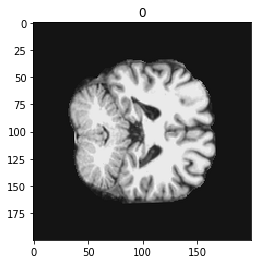

[0,    60] loss: 0.71641
Time elapsed: 0h:0m:7s
train accuracy_score: 56.80 %
val accuracy_score: 54.76 %
Val loss: 0.687430
[1,    60] loss: 0.67159
Time elapsed: 0h:0m:14s
train accuracy_score: 59.47 %
val accuracy_score: 57.14 %
Val loss: 0.677737
[2,    60] loss: 0.68054
Time elapsed: 0h:0m:22s
train accuracy_score: 60.95 %
val accuracy_score: 64.29 %
Val loss: 0.657737
[3,    60] loss: 0.66737
Time elapsed: 0h:0m:30s
train accuracy_score: 57.99 %
val accuracy_score: 61.90 %
Val loss: 0.657161
[4,    60] loss: 0.65302
Time elapsed: 0h:0m:37s
train accuracy_score: 61.83 %
val accuracy_score: 64.29 %
Val loss: 0.655069
[5,    60] loss: 0.60826
Time elapsed: 0h:0m:45s
train accuracy_score: 62.43 %
val accuracy_score: 61.90 %
Val loss: 0.695693
[6,    60] loss: 0.63771
Time elapsed: 0h:0m:53s
train accuracy_score: 64.20 %
val accuracy_score: 66.67 %
Val loss: 0.651955
[7,    60] loss: 0.60360
Time elapsed: 0h:1m:0s
train accuracy_score: 67.75 %
val accuracy_score: 64.29 %
Val loss: 0.6

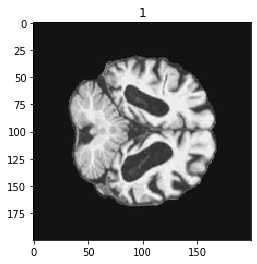

[0,    60] loss: 0.77466
Time elapsed: 0h:0m:7s
train accuracy_score: 53.25 %
val accuracy_score: 57.14 %
Val loss: 0.692712
[1,    60] loss: 0.73085
Time elapsed: 0h:0m:14s
train accuracy_score: 54.73 %
val accuracy_score: 54.76 %
Val loss: 0.702089
[2,    60] loss: 0.69803
Time elapsed: 0h:0m:22s
train accuracy_score: 51.78 %
val accuracy_score: 50.00 %
Val loss: 0.689608
[3,    60] loss: 0.68723
Time elapsed: 0h:0m:30s
train accuracy_score: 59.76 %
val accuracy_score: 52.38 %
Val loss: 0.679818
[4,    60] loss: 0.68824
Time elapsed: 0h:0m:38s
train accuracy_score: 59.17 %
val accuracy_score: 54.76 %
Val loss: 0.680831
[5,    60] loss: 0.66828
Time elapsed: 0h:0m:46s
train accuracy_score: 61.24 %
val accuracy_score: 59.52 %
Val loss: 0.680795
[6,    60] loss: 0.64074
Time elapsed: 0h:0m:53s
train accuracy_score: 66.27 %
val accuracy_score: 57.14 %
Val loss: 0.722452
[7,    60] loss: 0.67838
Time elapsed: 0h:1m:1s
train accuracy_score: 60.65 %
val accuracy_score: 57.14 %
Val loss: 0.6

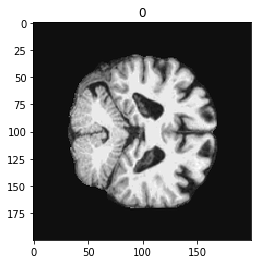

[0,    60] loss: 0.75027
Time elapsed: 0h:0m:7s
train accuracy_score: 52.37 %
val accuracy_score: 57.14 %
Val loss: 0.680726
[1,    60] loss: 0.72001
Time elapsed: 0h:0m:15s
train accuracy_score: 52.37 %
val accuracy_score: 57.14 %
Val loss: 0.675671
[2,    60] loss: 0.67932
Time elapsed: 0h:0m:22s
train accuracy_score: 58.58 %
val accuracy_score: 54.76 %
Val loss: 0.716361
[3,    60] loss: 0.66149
Time elapsed: 0h:0m:30s
train accuracy_score: 59.76 %
val accuracy_score: 61.90 %
Val loss: 0.674173
[4,    60] loss: 0.65723
Time elapsed: 0h:0m:38s
train accuracy_score: 60.95 %
val accuracy_score: 61.90 %
Val loss: 0.665135
[5,    60] loss: 0.64244
Time elapsed: 0h:0m:45s
train accuracy_score: 63.02 %
val accuracy_score: 52.38 %
Val loss: 0.680129
[6,    60] loss: 0.64726
Time elapsed: 0h:0m:53s
train accuracy_score: 61.83 %
val accuracy_score: 61.90 %
Val loss: 0.650727
[7,    60] loss: 0.66306
Time elapsed: 0h:1m:0s
train accuracy_score: 60.06 %
val accuracy_score: 61.90 %
Val loss: 0.6

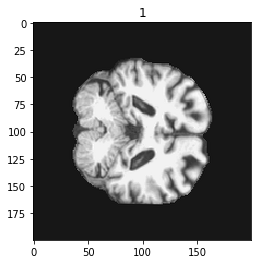

[0,    60] loss: 0.74781
Time elapsed: 0h:0m:8s
train accuracy_score: 50.00 %
val accuracy_score: 54.76 %
Val loss: 0.700031
[1,    60] loss: 0.73801
Time elapsed: 0h:0m:17s
train accuracy_score: 52.66 %
val accuracy_score: 57.14 %
Val loss: 0.676629
[2,    60] loss: 0.69088
Time elapsed: 0h:0m:25s
train accuracy_score: 54.44 %
val accuracy_score: 57.14 %
Val loss: 0.672745
[3,    60] loss: 0.67654
Time elapsed: 0h:0m:34s
train accuracy_score: 57.10 %
val accuracy_score: 50.00 %
Val loss: 0.694946
[4,    60] loss: 0.67195
Time elapsed: 0h:0m:42s
train accuracy_score: 55.92 %
val accuracy_score: 61.90 %
Val loss: 0.657306
[5,    60] loss: 0.64344
Time elapsed: 0h:0m:50s
train accuracy_score: 62.72 %
val accuracy_score: 59.52 %
Val loss: 0.665931
[6,    60] loss: 0.64361
Time elapsed: 0h:0m:58s
train accuracy_score: 64.20 %
val accuracy_score: 66.67 %
Val loss: 0.652436
[7,    60] loss: 0.63045
Time elapsed: 0h:1m:9s
train accuracy_score: 64.20 %
val accuracy_score: 64.29 %
Val loss: 0.6

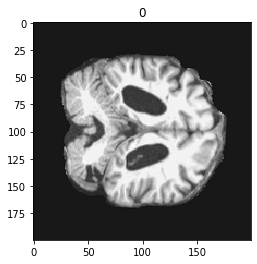

[0,    60] loss: 0.73506
Time elapsed: 0h:0m:11s
train accuracy_score: 50.89 %
val accuracy_score: 54.76 %
Val loss: 0.692929
[1,    60] loss: 0.69558
Time elapsed: 0h:0m:22s
train accuracy_score: 55.03 %
val accuracy_score: 54.76 %
Val loss: 0.675817
[2,    60] loss: 0.68604
Time elapsed: 0h:0m:33s
train accuracy_score: 54.44 %
val accuracy_score: 50.00 %
Val loss: 0.693077
[3,    60] loss: 0.69578
Time elapsed: 0h:0m:44s
train accuracy_score: 54.14 %
val accuracy_score: 54.76 %
Val loss: 0.698962
[4,    60] loss: 0.67986
Time elapsed: 0h:0m:55s
train accuracy_score: 62.13 %
val accuracy_score: 57.14 %
Val loss: 0.672945
[5,    60] loss: 0.66937
Time elapsed: 0h:1m:8s
train accuracy_score: 57.69 %
val accuracy_score: 61.90 %
Val loss: 0.665924
[6,    60] loss: 0.65613
Time elapsed: 0h:1m:25s
train accuracy_score: 61.24 %
val accuracy_score: 61.90 %
Val loss: 0.662740
[7,    60] loss: 0.64381
Time elapsed: 0h:1m:43s
train accuracy_score: 62.72 %
val accuracy_score: 59.52 %
Val loss: 0.

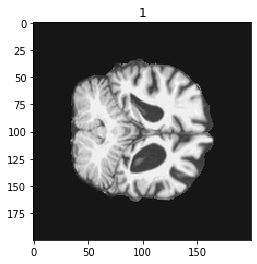

[0,    60] loss: 0.75388
Time elapsed: 0h:0m:11s
train accuracy_score: 47.93 %
val accuracy_score: 57.14 %
Val loss: 0.677798
[1,    60] loss: 0.74821
Time elapsed: 0h:0m:24s
train accuracy_score: 50.30 %
val accuracy_score: 54.76 %
Val loss: 0.669661
[2,    60] loss: 0.71432
Time elapsed: 0h:0m:37s
train accuracy_score: 57.10 %
val accuracy_score: 54.76 %
Val loss: 0.672088
[3,    60] loss: 0.67844
Time elapsed: 0h:0m:49s
train accuracy_score: 56.51 %
val accuracy_score: 54.76 %
Val loss: 0.668997
[4,    60] loss: 0.67466
Time elapsed: 0h:1m:2s
train accuracy_score: 59.17 %
val accuracy_score: 69.05 %
Val loss: 0.658255
[5,    60] loss: 0.66411
Time elapsed: 0h:1m:14s
train accuracy_score: 62.13 %
val accuracy_score: 64.29 %
Val loss: 0.648685
[6,    60] loss: 0.64929
Time elapsed: 0h:1m:26s
train accuracy_score: 61.83 %
val accuracy_score: 61.90 %
Val loss: 0.661796
[7,    60] loss: 0.64657
Time elapsed: 0h:1m:39s
train accuracy_score: 62.72 %
val accuracy_score: 69.05 %
Val loss: 0.

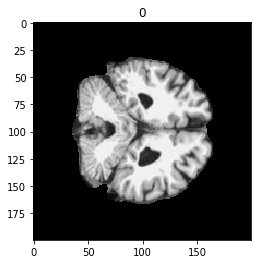

[0,    60] loss: 0.75701
Time elapsed: 0h:0m:11s
train accuracy_score: 48.82 %
val accuracy_score: 57.14 %
Val loss: 0.688477
[1,    60] loss: 0.71483
Time elapsed: 0h:0m:24s
train accuracy_score: 52.66 %
val accuracy_score: 57.14 %
Val loss: 0.679116
[2,    60] loss: 0.70255
Time elapsed: 0h:0m:36s
train accuracy_score: 51.18 %
val accuracy_score: 61.90 %
Val loss: 0.672329
[3,    60] loss: 0.71291
Time elapsed: 0h:0m:49s
train accuracy_score: 51.18 %
val accuracy_score: 59.52 %
Val loss: 0.670724
[4,    60] loss: 0.68617
Time elapsed: 0h:1m:1s
train accuracy_score: 56.80 %
val accuracy_score: 57.14 %
Val loss: 0.678665
[5,    60] loss: 0.67158
Time elapsed: 0h:1m:13s
train accuracy_score: 58.88 %
val accuracy_score: 59.52 %
Val loss: 0.659171
[6,    60] loss: 0.65596
Time elapsed: 0h:1m:26s
train accuracy_score: 59.47 %
val accuracy_score: 52.38 %
Val loss: 0.668336
[7,    60] loss: 0.68097
Time elapsed: 0h:1m:38s
train accuracy_score: 59.17 %
val accuracy_score: 57.14 %
Val loss: 0.

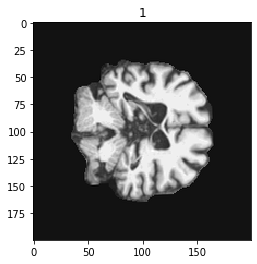

[0,    60] loss: 0.75376
Time elapsed: 0h:0m:11s
train accuracy_score: 52.37 %
val accuracy_score: 54.76 %
Val loss: 0.696278
[1,    60] loss: 0.71817
Time elapsed: 0h:0m:24s
train accuracy_score: 56.80 %
val accuracy_score: 42.86 %
Val loss: 0.712548
[2,    60] loss: 0.73501
Time elapsed: 0h:0m:37s
train accuracy_score: 52.66 %
val accuracy_score: 59.52 %
Val loss: 0.663897
[3,    60] loss: 0.67011
Time elapsed: 0h:0m:50s
train accuracy_score: 56.21 %
val accuracy_score: 59.52 %
Val loss: 0.662971
[4,    60] loss: 0.65523
Time elapsed: 0h:1m:3s
train accuracy_score: 58.88 %
val accuracy_score: 66.67 %
Val loss: 0.657042
[5,    60] loss: 0.64209
Time elapsed: 0h:1m:15s
train accuracy_score: 62.13 %
val accuracy_score: 59.52 %
Val loss: 0.657727
[6,    60] loss: 0.66840
Time elapsed: 0h:1m:28s
train accuracy_score: 62.72 %
val accuracy_score: 64.29 %
Val loss: 0.662502
[7,    60] loss: 0.65351
Time elapsed: 0h:1m:41s
train accuracy_score: 58.58 %
val accuracy_score: 47.62 %
Val loss: 0.

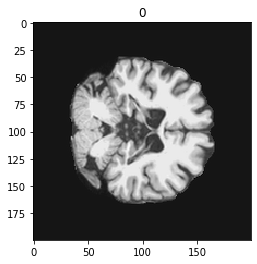

[0,    60] loss: 0.72091
Time elapsed: 0h:0m:12s
train accuracy_score: 54.44 %
val accuracy_score: 47.62 %
Val loss: 0.698032
[1,    60] loss: 0.70386
Time elapsed: 0h:0m:25s
train accuracy_score: 60.36 %
val accuracy_score: 61.90 %
Val loss: 0.688235
[2,    60] loss: 0.68937
Time elapsed: 0h:0m:37s
train accuracy_score: 56.51 %
val accuracy_score: 57.14 %
Val loss: 0.681222
[3,    60] loss: 0.72840
Time elapsed: 0h:0m:50s
train accuracy_score: 50.30 %
val accuracy_score: 54.76 %
Val loss: 0.678814
[4,    60] loss: 0.67821
Time elapsed: 0h:1m:2s
train accuracy_score: 57.10 %
val accuracy_score: 57.14 %
Val loss: 0.670365
[5,    60] loss: 0.70503
Time elapsed: 0h:1m:15s
train accuracy_score: 57.99 %
val accuracy_score: 54.76 %
Val loss: 0.685501
[6,    60] loss: 0.65066
Time elapsed: 0h:1m:27s
train accuracy_score: 59.17 %
val accuracy_score: 57.14 %
Val loss: 0.675557
[7,    60] loss: 0.63851
Time elapsed: 0h:1m:40s
train accuracy_score: 65.09 %
val accuracy_score: 57.14 %
Val loss: 0.

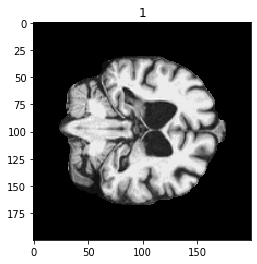

[0,    60] loss: 0.72966
Time elapsed: 0h:0m:10s
train accuracy_score: 50.30 %
val accuracy_score: 45.24 %
Val loss: 0.720011
[1,    60] loss: 0.72796
Time elapsed: 0h:0m:25s
train accuracy_score: 51.18 %
val accuracy_score: 52.38 %
Val loss: 0.691915
[2,    60] loss: 0.69453
Time elapsed: 0h:0m:41s
train accuracy_score: 55.33 %
val accuracy_score: 52.38 %
Val loss: 0.693968
[3,    60] loss: 0.67644
Time elapsed: 0h:0m:59s
train accuracy_score: 57.99 %
val accuracy_score: 45.24 %
Val loss: 0.726593
[4,    60] loss: 0.65942
Time elapsed: 0h:1m:16s
train accuracy_score: 61.24 %
val accuracy_score: 61.90 %
Val loss: 0.661612
[5,    60] loss: 0.65973
Time elapsed: 0h:1m:31s
train accuracy_score: 60.95 %
val accuracy_score: 64.29 %
Val loss: 0.657439
[6,    60] loss: 0.66179
Time elapsed: 0h:1m:46s
train accuracy_score: 59.47 %
val accuracy_score: 59.52 %
Val loss: 0.650085
[7,    60] loss: 0.63762
Time elapsed: 0h:2m:1s
train accuracy_score: 64.20 %
val accuracy_score: 69.05 %
Val loss: 0.

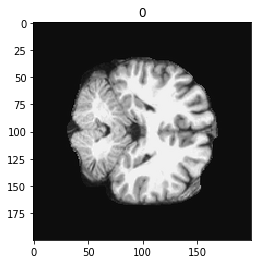

[0,    60] loss: 0.74972
Time elapsed: 0h:0m:12s
train accuracy_score: 48.22 %
val accuracy_score: 54.76 %
Val loss: 0.682823
[1,    60] loss: 0.71394
Time elapsed: 0h:0m:24s
train accuracy_score: 50.59 %
val accuracy_score: 59.52 %
Val loss: 0.673423
[2,    60] loss: 0.68956
Time elapsed: 0h:0m:37s
train accuracy_score: 56.21 %
val accuracy_score: 57.14 %
Val loss: 0.666184
[3,    60] loss: 0.67863
Time elapsed: 0h:0m:50s
train accuracy_score: 54.73 %
val accuracy_score: 45.24 %
Val loss: 0.706682
[4,    60] loss: 0.69523
Time elapsed: 0h:1m:2s
train accuracy_score: 58.28 %
val accuracy_score: 52.38 %
Val loss: 0.680019
[5,    60] loss: 0.66846
Time elapsed: 0h:1m:15s
train accuracy_score: 58.28 %
val accuracy_score: 64.29 %
Val loss: 0.671984
[6,    60] loss: 0.67017
Time elapsed: 0h:1m:28s
train accuracy_score: 61.54 %
val accuracy_score: 64.29 %
Val loss: 0.674154
[7,    60] loss: 0.68849
Time elapsed: 0h:1m:40s
train accuracy_score: 58.58 %
val accuracy_score: 59.52 %
Val loss: 0.

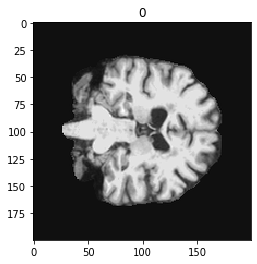

[0,    60] loss: 0.71033
Time elapsed: 0h:0m:11s
train accuracy_score: 54.73 %
val accuracy_score: 45.24 %
Val loss: 0.737100
[1,    60] loss: 0.72327
Time elapsed: 0h:0m:24s
train accuracy_score: 53.85 %
val accuracy_score: 57.14 %
Val loss: 0.684530
[2,    60] loss: 0.67243
Time elapsed: 0h:0m:36s
train accuracy_score: 56.21 %
val accuracy_score: 45.24 %
Val loss: 0.723594
[3,    60] loss: 0.66195
Time elapsed: 0h:0m:49s
train accuracy_score: 58.58 %
val accuracy_score: 47.62 %
Val loss: 0.697338
[4,    60] loss: 0.67373
Time elapsed: 0h:1m:2s
train accuracy_score: 60.36 %
val accuracy_score: 59.52 %
Val loss: 0.681412
[5,    60] loss: 0.64337
Time elapsed: 0h:1m:14s
train accuracy_score: 58.58 %
val accuracy_score: 54.76 %
Val loss: 0.666381
[6,    60] loss: 0.66143
Time elapsed: 0h:1m:27s
train accuracy_score: 62.13 %
val accuracy_score: 66.67 %
Val loss: 0.649357
[7,    60] loss: 0.60740
Time elapsed: 0h:1m:40s
train accuracy_score: 68.34 %
val accuracy_score: 64.29 %
Val loss: 0.

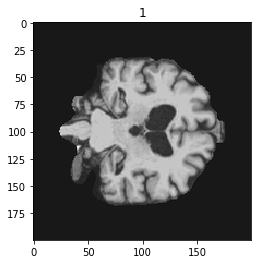

[0,    60] loss: 0.74309
Time elapsed: 0h:0m:25s
train accuracy_score: 52.96 %
val accuracy_score: 54.76 %
Val loss: 0.722027
[1,    60] loss: 0.70076
Time elapsed: 0h:0m:46s
train accuracy_score: 52.07 %
val accuracy_score: 54.76 %
Val loss: 0.700112
[2,    60] loss: 0.70065
Time elapsed: 0h:1m:5s
train accuracy_score: 54.14 %
val accuracy_score: 54.76 %
Val loss: 0.692044
[3,    60] loss: 0.67850
Time elapsed: 0h:1m:21s
train accuracy_score: 58.28 %
val accuracy_score: 54.76 %
Val loss: 0.724851
[4,    60] loss: 0.69643
Time elapsed: 0h:1m:35s
train accuracy_score: 59.47 %
val accuracy_score: 59.52 %
Val loss: 0.684791
[5,    60] loss: 0.66094
Time elapsed: 0h:1m:51s
train accuracy_score: 61.24 %
val accuracy_score: 59.52 %
Val loss: 0.678206
[6,    60] loss: 0.68848
Time elapsed: 0h:2m:5s
train accuracy_score: 54.44 %
val accuracy_score: 50.00 %
Val loss: 0.691284
[7,    60] loss: 0.65360
Time elapsed: 0h:2m:18s
train accuracy_score: 58.58 %
val accuracy_score: 47.62 %
Val loss: 0.7

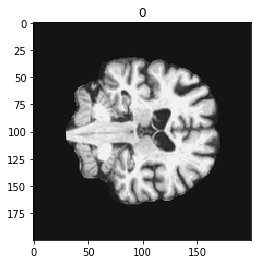

[0,    60] loss: 0.76449
Time elapsed: 0h:0m:12s
train accuracy_score: 50.00 %
val accuracy_score: 54.76 %
Val loss: 0.696240
[1,    60] loss: 0.73803
Time elapsed: 0h:0m:25s
train accuracy_score: 50.59 %
val accuracy_score: 57.14 %
Val loss: 0.688666
[2,    60] loss: 0.68448
Time elapsed: 0h:0m:37s
train accuracy_score: 55.62 %
val accuracy_score: 50.00 %
Val loss: 0.691947
[3,    60] loss: 0.64189
Time elapsed: 0h:0m:50s
train accuracy_score: 57.99 %
val accuracy_score: 47.62 %
Val loss: 0.703703
[4,    60] loss: 0.67041
Time elapsed: 0h:1m:3s
train accuracy_score: 57.69 %
val accuracy_score: 66.67 %
Val loss: 0.656130
[5,    60] loss: 0.67931
Time elapsed: 0h:1m:16s
train accuracy_score: 57.69 %
val accuracy_score: 61.90 %
Val loss: 0.653618
[6,    60] loss: 0.66117
Time elapsed: 0h:1m:29s
train accuracy_score: 61.24 %
val accuracy_score: 61.90 %
Val loss: 0.643215
[7,    60] loss: 0.61490
Time elapsed: 0h:1m:43s
train accuracy_score: 65.09 %
val accuracy_score: 59.52 %
Val loss: 0.

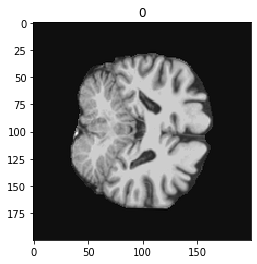

[0,    60] loss: 0.72369
Time elapsed: 0h:0m:11s
train accuracy_score: 52.96 %
val accuracy_score: 47.62 %
Val loss: 0.703853
[1,    60] loss: 0.71222
Time elapsed: 0h:0m:24s
train accuracy_score: 56.21 %
val accuracy_score: 45.24 %
Val loss: 0.740741
[2,    60] loss: 0.67921
Time elapsed: 0h:0m:36s
train accuracy_score: 58.88 %
val accuracy_score: 61.90 %
Val loss: 0.671734
[3,    60] loss: 0.65864
Time elapsed: 0h:0m:49s
train accuracy_score: 60.36 %
val accuracy_score: 59.52 %
Val loss: 0.672537
[4,    60] loss: 0.69983
Time elapsed: 0h:1m:2s
train accuracy_score: 56.21 %
val accuracy_score: 59.52 %
Val loss: 0.666336
[5,    60] loss: 0.65878
Time elapsed: 0h:1m:15s
train accuracy_score: 61.83 %
val accuracy_score: 57.14 %
Val loss: 0.658889
[6,    60] loss: 0.63703
Time elapsed: 0h:1m:27s
train accuracy_score: 64.50 %
val accuracy_score: 59.52 %
Val loss: 0.693135
[7,    60] loss: 0.69134
Time elapsed: 0h:1m:40s
train accuracy_score: 63.02 %
val accuracy_score: 64.29 %
Val loss: 0.

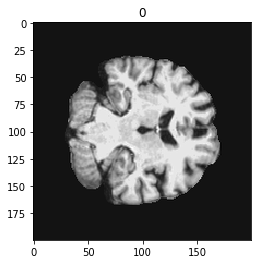

[0,    60] loss: 0.75975
Time elapsed: 0h:0m:11s
train accuracy_score: 50.00 %
val accuracy_score: 50.00 %
Val loss: 0.694959
[1,    60] loss: 0.76301
Time elapsed: 0h:0m:30s
train accuracy_score: 52.07 %
val accuracy_score: 54.76 %
Val loss: 0.685738
[2,    60] loss: 0.67248
Time elapsed: 0h:0m:43s
train accuracy_score: 58.28 %
val accuracy_score: 54.76 %
Val loss: 0.671236
[3,    60] loss: 0.67230
Time elapsed: 0h:0m:57s
train accuracy_score: 55.92 %
val accuracy_score: 61.90 %
Val loss: 0.647336
[4,    60] loss: 0.66638
Time elapsed: 0h:1m:11s
train accuracy_score: 62.43 %
val accuracy_score: 71.43 %
Val loss: 0.646549
[5,    60] loss: 0.64867
Time elapsed: 0h:1m:22s
train accuracy_score: 63.91 %
val accuracy_score: 64.29 %
Val loss: 0.633981
[6,    60] loss: 0.65196
Time elapsed: 0h:1m:34s
train accuracy_score: 62.13 %
val accuracy_score: 57.14 %
Val loss: 0.697969
[7,    60] loss: 0.64921
Time elapsed: 0h:1m:46s
train accuracy_score: 63.61 %
val accuracy_score: 57.14 %
Val loss: 0

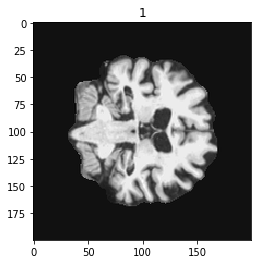

[0,    60] loss: 0.76567
Time elapsed: 0h:0m:11s
train accuracy_score: 49.70 %
val accuracy_score: 54.76 %
Val loss: 0.682630
[1,    60] loss: 0.73313
Time elapsed: 0h:0m:24s
train accuracy_score: 53.25 %
val accuracy_score: 54.76 %
Val loss: 0.700073
[2,    60] loss: 0.69897
Time elapsed: 0h:0m:36s
train accuracy_score: 53.25 %
val accuracy_score: 59.52 %
Val loss: 0.678177
[3,    60] loss: 0.67585
Time elapsed: 0h:0m:48s
train accuracy_score: 59.47 %
val accuracy_score: 59.52 %
Val loss: 0.657214
[4,    60] loss: 0.66176
Time elapsed: 0h:1m:0s
train accuracy_score: 63.61 %
val accuracy_score: 73.81 %
Val loss: 0.654674
[5,    60] loss: 0.66891
Time elapsed: 0h:1m:12s
train accuracy_score: 57.69 %
val accuracy_score: 64.29 %
Val loss: 0.665402
[6,    60] loss: 0.63453
Time elapsed: 0h:1m:25s
train accuracy_score: 63.02 %
val accuracy_score: 69.05 %
Val loss: 0.650376
[7,    60] loss: 0.61492
Time elapsed: 0h:1m:37s
train accuracy_score: 65.09 %
val accuracy_score: 66.67 %
Val loss: 0.

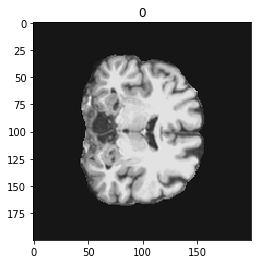

[0,    60] loss: 0.76041
Time elapsed: 0h:0m:11s
train accuracy_score: 50.89 %
val accuracy_score: 54.76 %
Val loss: 0.680690
[1,    60] loss: 0.72545
Time elapsed: 0h:0m:23s
train accuracy_score: 49.41 %
val accuracy_score: 59.52 %
Val loss: 0.673314
[2,    60] loss: 0.70145
Time elapsed: 0h:0m:35s
train accuracy_score: 54.73 %
val accuracy_score: 52.38 %
Val loss: 0.687116
[3,    60] loss: 0.69722
Time elapsed: 0h:0m:47s
train accuracy_score: 52.07 %
val accuracy_score: 64.29 %
Val loss: 0.665113
[4,    60] loss: 0.69185
Time elapsed: 0h:0m:59s
train accuracy_score: 57.10 %
val accuracy_score: 61.90 %
Val loss: 0.658260
[5,    60] loss: 0.68091
Time elapsed: 0h:1m:12s
train accuracy_score: 61.24 %
val accuracy_score: 61.90 %
Val loss: 0.648044
[6,    60] loss: 0.69116
Time elapsed: 0h:1m:24s
train accuracy_score: 56.21 %
val accuracy_score: 61.90 %
Val loss: 0.656730
[7,    60] loss: 0.64493
Time elapsed: 0h:1m:35s
train accuracy_score: 60.06 %
val accuracy_score: 47.62 %
Val loss: 0

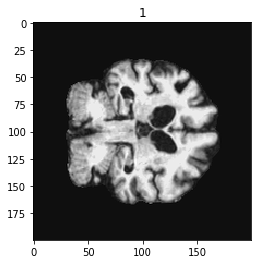

[0,    60] loss: 0.74799
Time elapsed: 0h:0m:12s
train accuracy_score: 49.41 %
val accuracy_score: 71.43 %
Val loss: 0.660538
[1,    60] loss: 0.68767
Time elapsed: 0h:0m:24s
train accuracy_score: 53.85 %
val accuracy_score: 54.76 %
Val loss: 0.676064
[2,    60] loss: 0.70576
Time elapsed: 0h:0m:36s
train accuracy_score: 56.51 %
val accuracy_score: 59.52 %
Val loss: 0.663735
[3,    60] loss: 0.66853
Time elapsed: 0h:0m:49s
train accuracy_score: 60.06 %
val accuracy_score: 57.14 %
Val loss: 0.681100
[4,    60] loss: 0.66522
Time elapsed: 0h:1m:2s
train accuracy_score: 57.69 %
val accuracy_score: 61.90 %
Val loss: 0.661478
[5,    60] loss: 0.66197
Time elapsed: 0h:1m:15s
train accuracy_score: 63.61 %
val accuracy_score: 50.00 %
Val loss: 0.684490
[6,    60] loss: 0.65797
Time elapsed: 0h:1m:27s
train accuracy_score: 64.79 %
val accuracy_score: 64.29 %
Val loss: 0.644105
[7,    60] loss: 0.64050
Time elapsed: 0h:1m:42s
train accuracy_score: 66.86 %
val accuracy_score: 50.00 %
Val loss: 0.

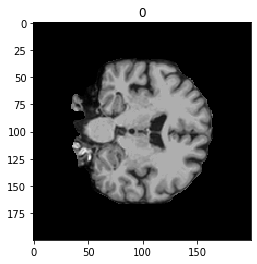

[0,    60] loss: 0.73305
Time elapsed: 0h:0m:11s
train accuracy_score: 55.92 %
val accuracy_score: 54.76 %
Val loss: 0.702623
[1,    60] loss: 0.71194
Time elapsed: 0h:0m:22s
train accuracy_score: 59.17 %
val accuracy_score: 54.76 %
Val loss: 0.686181
[2,    60] loss: 0.70052
Time elapsed: 0h:0m:36s
train accuracy_score: 56.51 %
val accuracy_score: 64.29 %
Val loss: 0.654567
[3,    60] loss: 0.66709
Time elapsed: 0h:0m:49s
train accuracy_score: 60.65 %
val accuracy_score: 64.29 %
Val loss: 0.648998
[4,    60] loss: 0.67030
Time elapsed: 0h:1m:2s
train accuracy_score: 63.91 %
val accuracy_score: 69.05 %
Val loss: 0.649515
[5,    60] loss: 0.63687
Time elapsed: 0h:1m:14s
train accuracy_score: 62.43 %
val accuracy_score: 69.05 %
Val loss: 0.637990
[6,    60] loss: 0.60499
Time elapsed: 0h:1m:28s
train accuracy_score: 67.16 %
val accuracy_score: 64.29 %
Val loss: 0.624533
[7,    60] loss: 0.62357
Time elapsed: 0h:1m:42s
train accuracy_score: 68.05 %
val accuracy_score: 69.05 %
Val loss: 0.

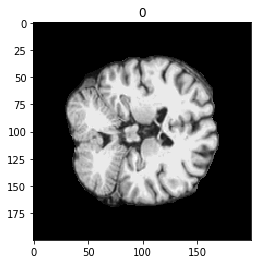

[0,    60] loss: 0.80975
Time elapsed: 0h:0m:12s
train accuracy_score: 50.30 %
val accuracy_score: 54.76 %
Val loss: 0.682125
[1,    60] loss: 0.71989
Time elapsed: 0h:0m:24s
train accuracy_score: 55.33 %
val accuracy_score: 52.38 %
Val loss: 0.694513
[2,    60] loss: 0.69680
Time elapsed: 0h:0m:36s
train accuracy_score: 55.62 %
val accuracy_score: 52.38 %
Val loss: 0.700444
[3,    60] loss: 0.65245
Time elapsed: 0h:0m:48s
train accuracy_score: 62.43 %
val accuracy_score: 64.29 %
Val loss: 0.657679
[4,    60] loss: 0.66332
Time elapsed: 0h:1m:1s
train accuracy_score: 63.31 %
val accuracy_score: 57.14 %
Val loss: 0.658407
[5,    60] loss: 0.62504
Time elapsed: 0h:1m:13s
train accuracy_score: 60.95 %
val accuracy_score: 59.52 %
Val loss: 0.665479
[6,    60] loss: 0.63957
Time elapsed: 0h:1m:26s
train accuracy_score: 63.61 %
val accuracy_score: 52.38 %
Val loss: 0.684882
[7,    60] loss: 0.67281
Time elapsed: 0h:1m:39s
train accuracy_score: 63.02 %
val accuracy_score: 61.90 %
Val loss: 0.

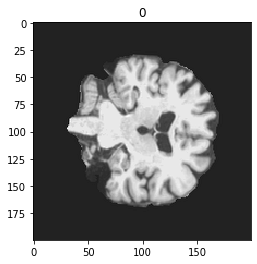

[0,    60] loss: 0.73346
Time elapsed: 0h:0m:11s
train accuracy_score: 50.30 %
val accuracy_score: 54.76 %
Val loss: 0.691973
[1,    60] loss: 0.69866
Time elapsed: 0h:0m:23s
train accuracy_score: 57.10 %
val accuracy_score: 47.62 %
Val loss: 0.697871
[2,    60] loss: 0.72543
Time elapsed: 0h:0m:36s
train accuracy_score: 52.37 %
val accuracy_score: 59.52 %
Val loss: 0.673595
[3,    60] loss: 0.69103
Time elapsed: 0h:0m:49s
train accuracy_score: 55.92 %
val accuracy_score: 52.38 %
Val loss: 0.668625
[4,    60] loss: 0.62511
Time elapsed: 0h:1m:1s
train accuracy_score: 64.20 %
val accuracy_score: 52.38 %
Val loss: 0.676591
[5,    60] loss: 0.65600
Time elapsed: 0h:1m:14s
train accuracy_score: 64.50 %
val accuracy_score: 69.05 %
Val loss: 0.641947
[6,    60] loss: 0.62911
Time elapsed: 0h:1m:26s
train accuracy_score: 67.16 %
val accuracy_score: 66.67 %
Val loss: 0.631542
[7,    60] loss: 0.61911
Time elapsed: 0h:1m:39s
train accuracy_score: 63.02 %
val accuracy_score: 64.29 %
Val loss: 0.

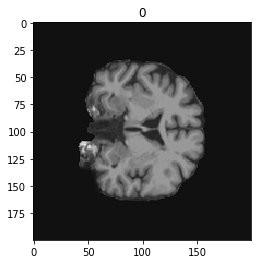

[0,    60] loss: 0.75182
Time elapsed: 0h:0m:11s
train accuracy_score: 49.70 %
val accuracy_score: 54.76 %
Val loss: 0.686413
[1,    60] loss: 0.72746
Time elapsed: 0h:0m:23s
train accuracy_score: 52.07 %
val accuracy_score: 54.76 %
Val loss: 0.688048
[2,    60] loss: 0.68795
Time elapsed: 0h:0m:35s
train accuracy_score: 52.07 %
val accuracy_score: 35.71 %
Val loss: 0.696426
[3,    60] loss: 0.67409
Time elapsed: 0h:0m:47s
train accuracy_score: 57.69 %
val accuracy_score: 42.86 %
Val loss: 0.701340
[4,    60] loss: 0.66299
Time elapsed: 0h:1m:0s
train accuracy_score: 63.02 %
val accuracy_score: 54.76 %
Val loss: 0.745223
[5,    60] loss: 0.68349
Time elapsed: 0h:1m:12s
train accuracy_score: 55.92 %
val accuracy_score: 59.52 %
Val loss: 0.667970
[6,    60] loss: 0.64698
Time elapsed: 0h:1m:24s
train accuracy_score: 63.61 %
val accuracy_score: 61.90 %
Val loss: 0.660115
[7,    60] loss: 0.63044
Time elapsed: 0h:1m:36s
train accuracy_score: 63.91 %
val accuracy_score: 59.52 %
Val loss: 0.

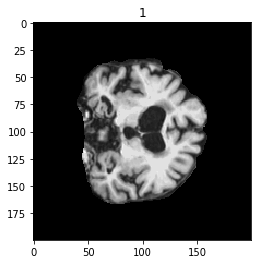

[0,    60] loss: 0.77529
Time elapsed: 0h:0m:10s
train accuracy_score: 49.11 %
val accuracy_score: 47.62 %
Val loss: 0.753137
[1,    60] loss: 0.70110
Time elapsed: 0h:0m:22s
train accuracy_score: 55.92 %
val accuracy_score: 52.38 %
Val loss: 0.688191
[2,    60] loss: 0.70688
Time elapsed: 0h:0m:33s
train accuracy_score: 55.62 %
val accuracy_score: 54.76 %
Val loss: 0.676804
[3,    60] loss: 0.67260
Time elapsed: 0h:0m:45s
train accuracy_score: 61.54 %
val accuracy_score: 61.90 %
Val loss: 0.665847
[4,    60] loss: 0.66680
Time elapsed: 0h:0m:57s
train accuracy_score: 61.24 %
val accuracy_score: 57.14 %
Val loss: 0.664851
[5,    60] loss: 0.60747
Time elapsed: 0h:1m:9s
train accuracy_score: 63.61 %
val accuracy_score: 45.24 %
Val loss: 0.773699
[6,    60] loss: 0.61956
Time elapsed: 0h:1m:21s
train accuracy_score: 65.38 %
val accuracy_score: 64.29 %
Val loss: 0.696829
[7,    60] loss: 0.59494
Time elapsed: 0h:1m:31s
train accuracy_score: 70.12 %
val accuracy_score: 66.67 %
Val loss: 0.

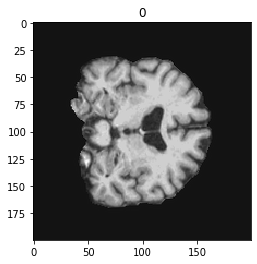

[0,    60] loss: 0.75084
Time elapsed: 0h:0m:11s
train accuracy_score: 50.30 %
val accuracy_score: 45.24 %
Val loss: 0.741284
[1,    60] loss: 0.72954
Time elapsed: 0h:0m:23s
train accuracy_score: 50.59 %
val accuracy_score: 57.14 %
Val loss: 0.674967
[2,    60] loss: 0.69929
Time elapsed: 0h:0m:35s
train accuracy_score: 55.33 %
val accuracy_score: 59.52 %
Val loss: 0.681797
[3,    60] loss: 0.68115
Time elapsed: 0h:0m:47s
train accuracy_score: 57.40 %
val accuracy_score: 59.52 %
Val loss: 0.680246
[4,    60] loss: 0.72076
Time elapsed: 0h:1m:0s
train accuracy_score: 55.33 %
val accuracy_score: 61.90 %
Val loss: 0.668346
[5,    60] loss: 0.67239
Time elapsed: 0h:1m:12s
train accuracy_score: 58.88 %
val accuracy_score: 59.52 %
Val loss: 0.685024
[6,    60] loss: 0.63560
Time elapsed: 0h:1m:25s
train accuracy_score: 62.13 %
val accuracy_score: 69.05 %
Val loss: 0.662242
[7,    60] loss: 0.61598
Time elapsed: 0h:1m:37s
train accuracy_score: 67.75 %
val accuracy_score: 61.90 %
Val loss: 0.

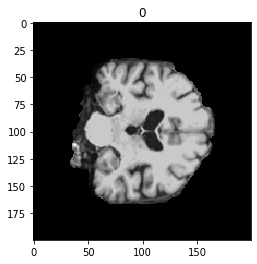

[0,    60] loss: 0.75929
Time elapsed: 0h:0m:11s
train accuracy_score: 48.52 %
val accuracy_score: 57.14 %
Val loss: 0.676419
[1,    60] loss: 0.69251
Time elapsed: 0h:0m:23s
train accuracy_score: 56.80 %
val accuracy_score: 47.62 %
Val loss: 0.698433
[2,    60] loss: 0.69580
Time elapsed: 0h:0m:36s
train accuracy_score: 52.96 %
val accuracy_score: 54.76 %
Val loss: 0.675124
[3,    60] loss: 0.68717
Time elapsed: 0h:0m:48s
train accuracy_score: 58.58 %
val accuracy_score: 50.00 %
Val loss: 0.717986
[4,    60] loss: 0.66542
Time elapsed: 0h:1m:0s
train accuracy_score: 57.10 %
val accuracy_score: 61.90 %
Val loss: 0.672512
[5,    60] loss: 0.67451
Time elapsed: 0h:1m:13s
train accuracy_score: 60.06 %
val accuracy_score: 52.38 %
Val loss: 0.676915
[6,    60] loss: 0.67662
Time elapsed: 0h:1m:25s
train accuracy_score: 59.17 %
val accuracy_score: 59.52 %
Val loss: 0.660027
[7,    60] loss: 0.66493
Time elapsed: 0h:1m:38s
train accuracy_score: 59.76 %
val accuracy_score: 61.90 %
Val loss: 0.

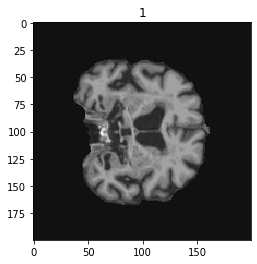

[0,    60] loss: 0.75346
Time elapsed: 0h:0m:11s
train accuracy_score: 55.03 %
val accuracy_score: 54.76 %
Val loss: 0.688736
[1,    60] loss: 0.73483
Time elapsed: 0h:0m:24s
train accuracy_score: 57.99 %
val accuracy_score: 57.14 %
Val loss: 0.674723
[2,    60] loss: 0.67362
Time elapsed: 0h:0m:36s
train accuracy_score: 57.40 %
val accuracy_score: 45.24 %
Val loss: 0.722512
[3,    60] loss: 0.64622
Time elapsed: 0h:0m:48s
train accuracy_score: 59.17 %
val accuracy_score: 57.14 %
Val loss: 0.686653
[4,    60] loss: 0.68253
Time elapsed: 0h:1m:0s
train accuracy_score: 60.36 %
val accuracy_score: 59.52 %
Val loss: 0.667252
[5,    60] loss: 0.67872
Time elapsed: 0h:1m:12s
train accuracy_score: 60.36 %
val accuracy_score: 57.14 %
Val loss: 0.670986
[6,    60] loss: 0.63174
Time elapsed: 0h:1m:25s
train accuracy_score: 60.95 %
val accuracy_score: 57.14 %
Val loss: 0.710290
[7,    60] loss: 0.68389
Time elapsed: 0h:1m:38s
train accuracy_score: 58.58 %
val accuracy_score: 57.14 %
Val loss: 0.

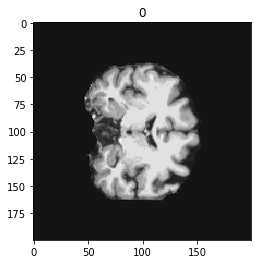

[0,    60] loss: 0.79561
Time elapsed: 0h:0m:12s
train accuracy_score: 49.41 %
val accuracy_score: 61.90 %
Val loss: 0.675329
[1,    60] loss: 0.73213
Time elapsed: 0h:0m:24s
train accuracy_score: 52.66 %
val accuracy_score: 54.76 %
Val loss: 0.704380
[2,    60] loss: 0.72304
Time elapsed: 0h:0m:37s
train accuracy_score: 49.70 %
val accuracy_score: 50.00 %
Val loss: 0.683232
[3,    60] loss: 0.70083
Time elapsed: 0h:0m:49s
train accuracy_score: 57.69 %
val accuracy_score: 61.90 %
Val loss: 0.671593
[4,    60] loss: 0.66230
Time elapsed: 0h:1m:2s
train accuracy_score: 57.69 %
val accuracy_score: 59.52 %
Val loss: 0.672745
[5,    60] loss: 0.65708
Time elapsed: 0h:1m:15s
train accuracy_score: 60.65 %
val accuracy_score: 57.14 %
Val loss: 0.676630
[6,    60] loss: 0.66985
Time elapsed: 0h:1m:28s
train accuracy_score: 59.47 %
val accuracy_score: 57.14 %
Val loss: 0.669038
[7,    60] loss: 0.64958
Time elapsed: 0h:1m:41s
train accuracy_score: 59.76 %
val accuracy_score: 54.76 %
Val loss: 0.

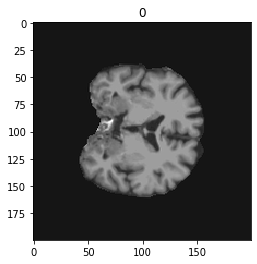

[0,    60] loss: 0.75877
Time elapsed: 0h:0m:8s
train accuracy_score: 50.30 %
val accuracy_score: 47.62 %
Val loss: 0.687870
[1,    60] loss: 0.72045
Time elapsed: 0h:0m:17s
train accuracy_score: 53.25 %
val accuracy_score: 61.90 %
Val loss: 0.691663
[2,    60] loss: 0.69262
Time elapsed: 0h:0m:25s
train accuracy_score: 53.85 %
val accuracy_score: 57.14 %
Val loss: 0.680599
[3,    60] loss: 0.69511
Time elapsed: 0h:0m:33s
train accuracy_score: 57.99 %
val accuracy_score: 54.76 %
Val loss: 0.683071
[4,    60] loss: 0.67620
Time elapsed: 0h:0m:42s
train accuracy_score: 59.76 %
val accuracy_score: 54.76 %
Val loss: 0.669368
[5,    60] loss: 0.65093
Time elapsed: 0h:0m:51s
train accuracy_score: 63.91 %
val accuracy_score: 54.76 %
Val loss: 0.689234
[6,    60] loss: 0.67723
Time elapsed: 0h:0m:59s
train accuracy_score: 59.76 %
val accuracy_score: 64.29 %
Val loss: 0.671693
[7,    60] loss: 0.62808
Time elapsed: 0h:1m:7s
train accuracy_score: 64.50 %
val accuracy_score: 57.14 %
Val loss: 0.6

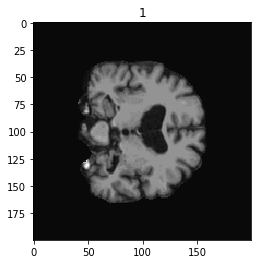

[0,    60] loss: 0.79936
Time elapsed: 0h:0m:8s
train accuracy_score: 46.45 %
val accuracy_score: 57.14 %
Val loss: 0.678795
[1,    60] loss: 0.73058
Time elapsed: 0h:0m:16s
train accuracy_score: 51.78 %
val accuracy_score: 59.52 %
Val loss: 0.673074
[2,    60] loss: 0.68823
Time elapsed: 0h:0m:24s
train accuracy_score: 57.10 %
val accuracy_score: 54.76 %
Val loss: 0.682229
[3,    60] loss: 0.70828
Time elapsed: 0h:0m:34s
train accuracy_score: 55.62 %
val accuracy_score: 61.90 %
Val loss: 0.676351
[4,    60] loss: 0.68567
Time elapsed: 0h:0m:42s
train accuracy_score: 52.66 %
val accuracy_score: 50.00 %
Val loss: 0.690890
[5,    60] loss: 0.67730
Time elapsed: 0h:0m:51s
train accuracy_score: 59.17 %
val accuracy_score: 54.76 %
Val loss: 0.680787
[6,    60] loss: 0.66344
Time elapsed: 0h:1m:2s
train accuracy_score: 56.21 %
val accuracy_score: 54.76 %
Val loss: 0.678889
[7,    60] loss: 0.67504
Time elapsed: 0h:1m:11s
train accuracy_score: 59.76 %
val accuracy_score: 50.00 %
Val loss: 0.6

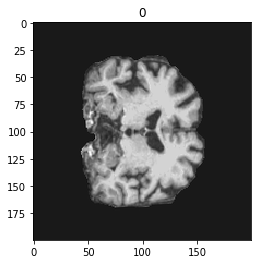

[0,    60] loss: 0.74630
Time elapsed: 0h:0m:7s
train accuracy_score: 50.89 %
val accuracy_score: 59.52 %
Val loss: 0.683496
[1,    60] loss: 0.72420
Time elapsed: 0h:0m:16s
train accuracy_score: 52.37 %
val accuracy_score: 54.76 %
Val loss: 0.682387
[2,    60] loss: 0.67325
Time elapsed: 0h:0m:24s
train accuracy_score: 57.10 %
val accuracy_score: 45.24 %
Val loss: 0.695921
[3,    60] loss: 0.67903
Time elapsed: 0h:0m:32s
train accuracy_score: 61.54 %
val accuracy_score: 64.29 %
Val loss: 0.663777
[4,    60] loss: 0.65828
Time elapsed: 0h:0m:40s
train accuracy_score: 56.80 %
val accuracy_score: 64.29 %
Val loss: 0.660108
[5,    60] loss: 0.65247
Time elapsed: 0h:0m:48s
train accuracy_score: 61.83 %
val accuracy_score: 61.90 %
Val loss: 0.668973
[6,    60] loss: 0.66907
Time elapsed: 0h:0m:56s
train accuracy_score: 60.65 %
val accuracy_score: 54.76 %
Val loss: 0.700623
[7,    60] loss: 0.64382
Time elapsed: 0h:1m:5s
train accuracy_score: 66.57 %
val accuracy_score: 64.29 %
Val loss: 0.6

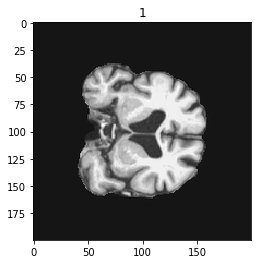

[0,    60] loss: 0.73971
Time elapsed: 0h:0m:8s
train accuracy_score: 50.89 %
val accuracy_score: 54.76 %
Val loss: 0.697332
[1,    60] loss: 0.72308
Time elapsed: 0h:0m:17s
train accuracy_score: 51.78 %
val accuracy_score: 57.14 %
Val loss: 0.692531
[2,    60] loss: 0.67207
Time elapsed: 0h:0m:26s
train accuracy_score: 54.73 %
val accuracy_score: 59.52 %
Val loss: 0.685575
[3,    60] loss: 0.69337
Time elapsed: 0h:0m:34s
train accuracy_score: 59.76 %
val accuracy_score: 59.52 %
Val loss: 0.681394
[4,    60] loss: 0.64620
Time elapsed: 0h:0m:42s
train accuracy_score: 62.43 %
val accuracy_score: 52.38 %
Val loss: 0.723685
[5,    60] loss: 0.62277
Time elapsed: 0h:0m:50s
train accuracy_score: 65.68 %
val accuracy_score: 52.38 %
Val loss: 0.683024
[6,    60] loss: 0.67281
Time elapsed: 0h:0m:58s
train accuracy_score: 63.61 %
val accuracy_score: 66.67 %
Val loss: 0.683221
[7,    60] loss: 0.62650
Time elapsed: 0h:1m:6s
train accuracy_score: 68.05 %
val accuracy_score: 54.76 %
Val loss: 0.7

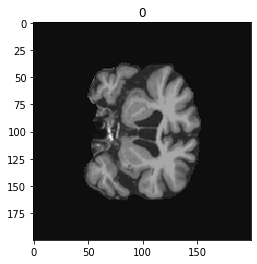

[0,    60] loss: 0.73976
Time elapsed: 0h:0m:7s
train accuracy_score: 55.03 %
val accuracy_score: 57.14 %
Val loss: 0.686586
[1,    60] loss: 0.73190
Time elapsed: 0h:0m:14s
train accuracy_score: 50.30 %
val accuracy_score: 50.00 %
Val loss: 0.691116
[2,    60] loss: 0.70763
Time elapsed: 0h:0m:22s
train accuracy_score: 55.92 %
val accuracy_score: 54.76 %
Val loss: 0.689665
[3,    60] loss: 0.65860
Time elapsed: 0h:0m:30s
train accuracy_score: 59.17 %
val accuracy_score: 52.38 %
Val loss: 0.685810
[4,    60] loss: 0.68396
Time elapsed: 0h:0m:37s
train accuracy_score: 57.69 %
val accuracy_score: 54.76 %
Val loss: 0.683377
[5,    60] loss: 0.64984
Time elapsed: 0h:0m:45s
train accuracy_score: 60.95 %
val accuracy_score: 57.14 %
Val loss: 0.675466
[6,    60] loss: 0.66555
Time elapsed: 0h:0m:52s
train accuracy_score: 61.83 %
val accuracy_score: 54.76 %
Val loss: 0.677730
[7,    60] loss: 0.64761
Time elapsed: 0h:1m:0s
train accuracy_score: 65.68 %
val accuracy_score: 61.90 %
Val loss: 0.6

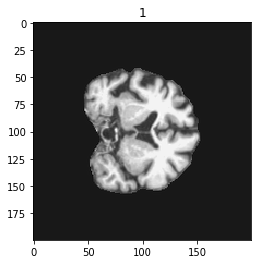

[0,    60] loss: 0.74830
Time elapsed: 0h:0m:7s
train accuracy_score: 51.48 %
val accuracy_score: 61.90 %
Val loss: 0.679352
[1,    60] loss: 0.70763
Time elapsed: 0h:0m:14s
train accuracy_score: 55.92 %
val accuracy_score: 45.24 %
Val loss: 0.770337
[2,    60] loss: 0.68984
Time elapsed: 0h:0m:22s
train accuracy_score: 55.62 %
val accuracy_score: 54.76 %
Val loss: 0.668134
[3,    60] loss: 0.71677
Time elapsed: 0h:0m:30s
train accuracy_score: 52.96 %
val accuracy_score: 61.90 %
Val loss: 0.664192
[4,    60] loss: 0.64777
Time elapsed: 0h:0m:37s
train accuracy_score: 59.17 %
val accuracy_score: 57.14 %
Val loss: 0.659608
[5,    60] loss: 0.67282
Time elapsed: 0h:0m:45s
train accuracy_score: 57.99 %
val accuracy_score: 57.14 %
Val loss: 0.659872
[6,    60] loss: 0.64519
Time elapsed: 0h:0m:53s
train accuracy_score: 60.95 %
val accuracy_score: 61.90 %
Val loss: 0.658152
[7,    60] loss: 0.66106
Time elapsed: 0h:1m:0s
train accuracy_score: 61.24 %
val accuracy_score: 59.52 %
Val loss: 0.6

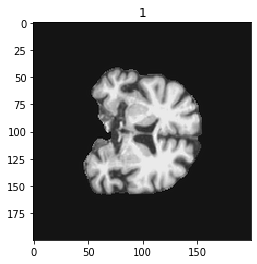

[0,    60] loss: 0.78904
Time elapsed: 0h:0m:7s
train accuracy_score: 45.86 %
val accuracy_score: 47.62 %
Val loss: 0.717251
[1,    60] loss: 0.72534
Time elapsed: 0h:0m:15s
train accuracy_score: 55.03 %
val accuracy_score: 52.38 %
Val loss: 0.684329
[2,    60] loss: 0.66965
Time elapsed: 0h:0m:23s
train accuracy_score: 55.03 %
val accuracy_score: 61.90 %
Val loss: 0.701047
[3,    60] loss: 0.69725
Time elapsed: 0h:0m:30s
train accuracy_score: 54.14 %
val accuracy_score: 52.38 %
Val loss: 0.684853
[4,    60] loss: 0.69928
Time elapsed: 0h:0m:38s
train accuracy_score: 54.73 %
val accuracy_score: 52.38 %
Val loss: 0.690737
[5,    60] loss: 0.66468
Time elapsed: 0h:0m:46s
train accuracy_score: 61.54 %
val accuracy_score: 57.14 %
Val loss: 0.692153
[6,    60] loss: 0.64785
Time elapsed: 0h:0m:54s
train accuracy_score: 62.43 %
val accuracy_score: 52.38 %
Val loss: 0.704757
[7,    60] loss: 0.66188
Time elapsed: 0h:1m:1s
train accuracy_score: 60.06 %
val accuracy_score: 59.52 %
Val loss: 0.6

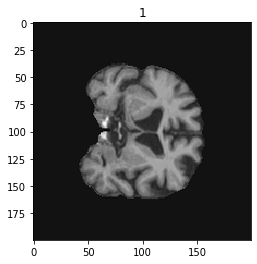

[0,    60] loss: 0.73206
Time elapsed: 0h:0m:7s
train accuracy_score: 52.66 %
val accuracy_score: 54.76 %
Val loss: 0.696474
[1,    60] loss: 0.69537
Time elapsed: 0h:0m:14s
train accuracy_score: 58.58 %
val accuracy_score: 50.00 %
Val loss: 0.689089
[2,    60] loss: 0.69439
Time elapsed: 0h:0m:22s
train accuracy_score: 51.18 %
val accuracy_score: 50.00 %
Val loss: 0.714718
[3,    60] loss: 0.67380
Time elapsed: 0h:0m:30s
train accuracy_score: 58.58 %
val accuracy_score: 54.76 %
Val loss: 0.693362
[4,    60] loss: 0.66857
Time elapsed: 0h:0m:37s
train accuracy_score: 57.99 %
val accuracy_score: 52.38 %
Val loss: 0.707615
[5,    60] loss: 0.66003
Time elapsed: 0h:0m:45s
train accuracy_score: 59.17 %
val accuracy_score: 57.14 %
Val loss: 0.685825
[6,    60] loss: 0.66571
Time elapsed: 0h:0m:53s
train accuracy_score: 57.40 %
val accuracy_score: 50.00 %
Val loss: 0.690370
[7,    60] loss: 0.66262
Time elapsed: 0h:1m:0s
train accuracy_score: 63.02 %
val accuracy_score: 52.38 %
Val loss: 0.6

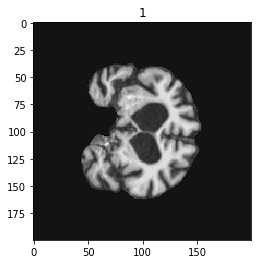

[0,    60] loss: 0.79363
Time elapsed: 0h:0m:7s
train accuracy_score: 49.41 %
val accuracy_score: 54.76 %
Val loss: 0.658485
[1,    60] loss: 0.70315
Time elapsed: 0h:0m:14s
train accuracy_score: 54.44 %
val accuracy_score: 66.67 %
Val loss: 0.661556
[2,    60] loss: 0.69519
Time elapsed: 0h:0m:22s
train accuracy_score: 57.40 %
val accuracy_score: 66.67 %
Val loss: 0.662246
[3,    60] loss: 0.69103
Time elapsed: 0h:0m:30s
train accuracy_score: 54.44 %
val accuracy_score: 52.38 %
Val loss: 0.656021
[4,    60] loss: 0.67818
Time elapsed: 0h:0m:37s
train accuracy_score: 56.21 %
val accuracy_score: 64.29 %
Val loss: 0.662492
[5,    60] loss: 0.68673
Time elapsed: 0h:0m:45s
train accuracy_score: 60.06 %
val accuracy_score: 69.05 %
Val loss: 0.647532
[6,    60] loss: 0.67981
Time elapsed: 0h:0m:53s
train accuracy_score: 55.03 %
val accuracy_score: 61.90 %
Val loss: 0.650459
[7,    60] loss: 0.66889
Time elapsed: 0h:1m:0s
train accuracy_score: 57.69 %
val accuracy_score: 54.76 %
Val loss: 0.6

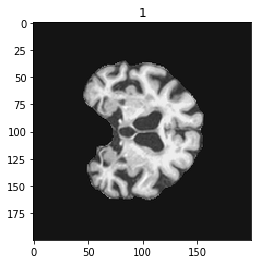

[0,    60] loss: 0.76654
Time elapsed: 0h:0m:7s
train accuracy_score: 48.82 %
val accuracy_score: 45.24 %
Val loss: 0.774903
[1,    60] loss: 0.70682
Time elapsed: 0h:0m:14s
train accuracy_score: 58.28 %
val accuracy_score: 47.62 %
Val loss: 0.668513
[2,    60] loss: 0.71072
Time elapsed: 0h:0m:22s
train accuracy_score: 56.21 %
val accuracy_score: 57.14 %
Val loss: 0.670350
[3,    60] loss: 0.68006
Time elapsed: 0h:0m:30s
train accuracy_score: 57.99 %
val accuracy_score: 54.76 %
Val loss: 0.682391
[4,    60] loss: 0.68620
Time elapsed: 0h:0m:37s
train accuracy_score: 53.25 %
val accuracy_score: 50.00 %
Val loss: 0.652876
[5,    60] loss: 0.67588
Time elapsed: 0h:0m:45s
train accuracy_score: 59.76 %
val accuracy_score: 54.76 %
Val loss: 0.692652
[6,    60] loss: 0.67385
Time elapsed: 0h:0m:53s
train accuracy_score: 61.24 %
val accuracy_score: 57.14 %
Val loss: 0.661353
[7,    60] loss: 0.67665
Time elapsed: 0h:1m:0s
train accuracy_score: 58.58 %
val accuracy_score: 73.81 %
Val loss: 0.6

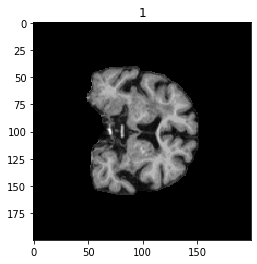

[0,    60] loss: 0.78815
Time elapsed: 0h:0m:7s
train accuracy_score: 52.07 %
val accuracy_score: 54.76 %
Val loss: 0.673499
[1,    60] loss: 0.71937
Time elapsed: 0h:0m:14s
train accuracy_score: 53.55 %
val accuracy_score: 61.90 %
Val loss: 0.661292
[2,    60] loss: 0.68392
Time elapsed: 0h:0m:22s
train accuracy_score: 57.69 %
val accuracy_score: 59.52 %
Val loss: 0.642327
[3,    60] loss: 0.69615
Time elapsed: 0h:0m:30s
train accuracy_score: 53.85 %
val accuracy_score: 57.14 %
Val loss: 0.648943
[4,    60] loss: 0.69366
Time elapsed: 0h:0m:38s
train accuracy_score: 53.25 %
val accuracy_score: 64.29 %
Val loss: 0.653225
[5,    60] loss: 0.67495
Time elapsed: 0h:0m:45s
train accuracy_score: 59.17 %
val accuracy_score: 61.90 %
Val loss: 0.663422
[6,    60] loss: 0.66932
Time elapsed: 0h:0m:53s
train accuracy_score: 58.28 %
val accuracy_score: 64.29 %
Val loss: 0.647724
[7,    60] loss: 0.69172
Time elapsed: 0h:1m:1s
train accuracy_score: 58.58 %
val accuracy_score: 61.90 %
Val loss: 0.6

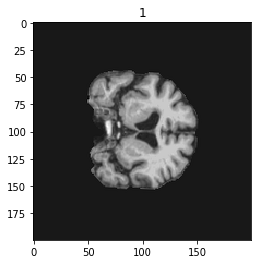

[0,    60] loss: 0.77771
Time elapsed: 0h:0m:7s
train accuracy_score: 49.41 %
val accuracy_score: 61.90 %
Val loss: 0.664584
[1,    60] loss: 0.71981
Time elapsed: 0h:0m:15s
train accuracy_score: 49.70 %
val accuracy_score: 54.76 %
Val loss: 0.683105
[2,    60] loss: 0.68177
Time elapsed: 0h:0m:22s
train accuracy_score: 57.10 %
val accuracy_score: 61.90 %
Val loss: 0.676785
[3,    60] loss: 0.68314
Time elapsed: 0h:0m:30s
train accuracy_score: 59.76 %
val accuracy_score: 57.14 %
Val loss: 0.662751
[4,    60] loss: 0.68126
Time elapsed: 0h:0m:38s
train accuracy_score: 59.76 %
val accuracy_score: 69.05 %
Val loss: 0.640166
[5,    60] loss: 0.65572
Time elapsed: 0h:0m:45s
train accuracy_score: 57.99 %
val accuracy_score: 54.76 %
Val loss: 0.652110
[6,    60] loss: 0.66473
Time elapsed: 0h:0m:53s
train accuracy_score: 60.65 %
val accuracy_score: 69.05 %
Val loss: 0.643835
[7,    60] loss: 0.65906
Time elapsed: 0h:1m:0s
train accuracy_score: 64.79 %
val accuracy_score: 64.29 %
Val loss: 0.6

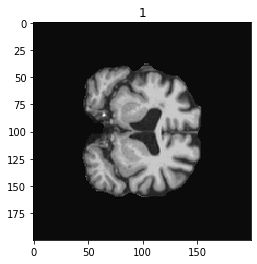

[0,    60] loss: 0.77166
Time elapsed: 0h:0m:7s
train accuracy_score: 47.63 %
val accuracy_score: 54.76 %
Val loss: 0.675479
[1,    60] loss: 0.70599
Time elapsed: 0h:0m:15s
train accuracy_score: 54.44 %
val accuracy_score: 54.76 %
Val loss: 0.727845
[2,    60] loss: 0.72889
Time elapsed: 0h:0m:22s
train accuracy_score: 53.85 %
val accuracy_score: 61.90 %
Val loss: 0.671818
[3,    60] loss: 0.68211
Time elapsed: 0h:0m:30s
train accuracy_score: 58.88 %
val accuracy_score: 54.76 %
Val loss: 0.650831
[4,    60] loss: 0.67623
Time elapsed: 0h:0m:38s
train accuracy_score: 57.69 %
val accuracy_score: 61.90 %
Val loss: 0.700286
[5,    60] loss: 0.71466
Time elapsed: 0h:0m:45s
train accuracy_score: 54.14 %
val accuracy_score: 52.38 %
Val loss: 0.645821
[6,    60] loss: 0.64723
Time elapsed: 0h:0m:53s
train accuracy_score: 62.43 %
val accuracy_score: 54.76 %
Val loss: 0.680139
[7,    60] loss: 0.65878
Time elapsed: 0h:1m:0s
train accuracy_score: 61.83 %
val accuracy_score: 54.76 %
Val loss: 0.6

In [11]:
for z_slice in range(0, 10):
    print('Starting slice {}'.format(z_slice))
    
    x_train_z = crop(x_train, z_slice=z_slice, dims=(200, 200))
    x_train_z = min_max(x_train_z)
    x_val_z = crop(x_val, z_slice=z_slice, dims=(200, 200))
    x_val_z = min_max(x_val_z)
    
    print(x_train_z.shape)
    print(x_val_z.shape)
    #print(y_train.shape)
    #print(y_val.shape)
    #print(sum(y_train))
    #print(sum(y_val))

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    class ADNIDataset(Dataset):
        def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=torch.float32, num_classes=2):
            self.X = np.copy(X)
            self.y = np.copy(y)
            self.X = X
            self.y = y
            self.transform = transform
            self.target_transform = target_transform
            self.mask = mask
            self.z_factor = z_factor
            self.dtype = dtype
            self.num_classes = num_classes

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            image = self.X[idx]
            label_tensor = np.zeros(shape=(self.num_classes,))
            label = self.y[idx] >= 0.5
            label = torch.LongTensor([label])

            if self.transform:
                image = self.transform(image)

            sample = {"image" : image,
                     "label" : label}
            return sample
    
    augmentations = [nitransform.SagittalRotate()]
    adni_data_train = ADNIDataset(x_train_z[:,0,:,:], y_train, transform = transforms.Compose(augmentations + [nitransform.ToTensor()]), 
                                  dtype=torch.float32)
    adni_data_val = ADNIDataset(x_val_z, y_val)
    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb for reference
    class ClassificationModel2D(nn.Module):

        def __init__(self, dropout=0.4, dropout2=0.4):
            nn.Module.__init__(self)
            self.Conv_1 = nn.Conv2d(1, 8, 3)
            self.Conv_1_bn = nn.BatchNorm2d(8)
            self.Conv_1_mp = nn.MaxPool2d(2)
            self.Conv_2 = nn.Conv2d(8, 16, 3)
            self.Conv_2_bn = nn.BatchNorm2d(16)
            self.Conv_2_mp = nn.MaxPool2d(3)
            self.Conv_3 = nn.Conv2d(16, 32, 3)
            self.Conv_3_bn = nn.BatchNorm2d(32)
            self.Conv_3_mp = nn.MaxPool2d(2)
            self.Conv_4 = nn.Conv2d(32, 64, 3)
            self.Conv_4_bn = nn.BatchNorm2d(64)
            self.Conv_4_mp = nn.MaxPool2d(3)
            self.dense_1 = nn.Linear(1024, 128)
            self.dense_2 = nn.Linear(128, 2)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)
            self.dropout2 = nn.Dropout(dropout2)

        def forward(self, x):
            x = x.float()
            x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
            x = self.Conv_1_mp(x)
            x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
            x = self.Conv_2_mp(x)
            x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
            x = self.Conv_3_mp(x)
            x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
            x = self.Conv_4_mp(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = self.relu(self.dense_1(x))
            x = self.dropout2(x)
            x = self.dense_2(x)
            return x

    net = ClassificationModel2D().float()

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    def run(
        net,
        data,
        shape,
        callbacks=[],
        augmentations=[],
        masked=False,
        metrics=[],
        k_folds=None,
        b=4,
        num_epochs=40,
        retain_metric=None):      

        fold_metric = []
        models = []
        fold = 0
        initial_prepend = None
        
        # set number of cross-validation folds
        for trial in range(5):
            print("Starting trial {}".format(trial))

            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
            fold += 1

            # restart model
            del net
            net = ClassificationModel2D().float()

            # reset hyperparameters
            lr = 1e-4
            wd = 1e-4
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(adni_data_train, batch_size=b, num_workers=0, shuffle=True)
            val_loader = DataLoader(adni_data_val, batch_size=1, num_workers=0, shuffle=True)

            # plot slice (optional)
            sample = next(iter(train_loader))
            img = sample["image"][0]
            lbl = sample["label"][0]
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(lbl.item())
            plt.show()
            model_trainer = trainer.Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=torch.device("cpu"),
                prediction_type="classification")

            # train model and store results
            net, report = model_trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=60,
                show_validation_epochs=1)
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                fold_metric.append(report["val_metrics"][retain_metric][-1])
            else:
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

            models.append(net)
            print("Finished fold.")

            # visualize result (optional)
            #model_trainer.visualize_training(report, metrics)
            #model_trainer.evaluate_model(val_loader)

        print("################################")
        print("################################")
        print("All accuracies: {}".format(fold_metric))
        return fold_metric, models

    net = ClassificationModel2D().float()
    num_epochs = 40
    min_iters = 3
    ignore_epochs = 15
    normalize = False
    retain_metric = accuracy_score
    metrics = [accuracy_score]
    model_path = 'C:/Users/Ben/Desktop/MRI_Mask/torch_10.1'
    r = 0

    check = ModelCheckpoint(path=model_path,
                            prepend="repeat_{}".format(r),
                            store_best=True,
                            ignore_before=ignore_epochs,
                            retain_metric=retain_metric)
    callbacks = [check, EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

    fold_metric, models = run(net=net, data=adni_data_train,
                      k_folds=-1,
                      callbacks=None,
                      shape=-1,
                      masked=False,
                      metrics=metrics,
                      num_epochs=num_epochs,
                      retain_metric=retain_metric,
                      b=4,
                     )

    print(np.mean(fold_metric))
    print(np.std(fold_metric))
    best = np.array(fold_metric).argmax()
    torch.save(models[best].state_dict(), model_path + '/' + '2D_Slice_' + str(z_slice))

# Classify the holdout set

In [13]:
y_hat = []
accuracies = []
with torch.no_grad():
    for _ in range(len(os.listdir(model_path))):
        z_slice = np.int(os.listdir(model_path)[_][-1:])
        x_test_z = crop(x_test, z_slice=z_slice, dims=(200, 200))
        x_test_z = min_max(x_test_z)
        test_loader = DataLoader(ADNIDataset(x_test_z, y_test), batch_size=1, num_workers=0, shuffle=False)
        all_preds = []
        all_labels = []
        model = ClassificationModel2D()
        model.load_state_dict(torch.load(model_path + '/' + os.listdir(model_path)[_]))
        model.eval()
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device('cpu'))
            output = model.forward(img)
            pred = torch.argmax(F.softmax(output, dim=1))
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
        print(all_preds)
        print(all_labels)
        print(classification_report(all_labels, all_preds))
        y_hat.append(all_preds)
        accuracies.append(classification_report(all_labels, all_preds, output_dict = True)['accuracy'])
        del model
y_test = y_test.astype(int)        
y_hat = ((np.mean(y_hat, axis = 0) >= .5)/1).astype(int)
print(y_test)
print(y_hat)
print(classification_report(y_test, y_hat))

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
              precision    recall  f1-score   support

           0       0.62      0.87      0.73        23
           1       0.73      0.40      0.52        20

    accuracy                           0.65        43
   macro avg       0.68      0.63      0.62        43
weighted avg       0.67      0.65      0.63        43

[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        23
           1       0.63      0.60      0.62 

# Visualize the misprediction

array([2, 9, 0, 1, 8, 6, 7, 5, 3, 4], dtype=int64)

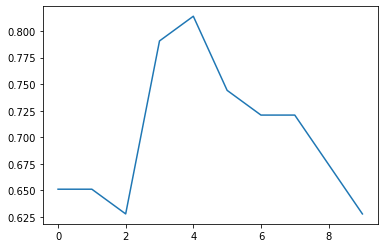

In [14]:
plt.plot(range(0,10), accuracies)
np.argsort(accuracies)

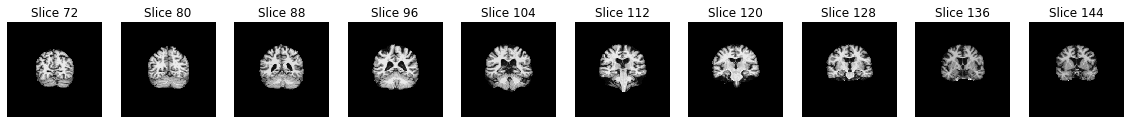

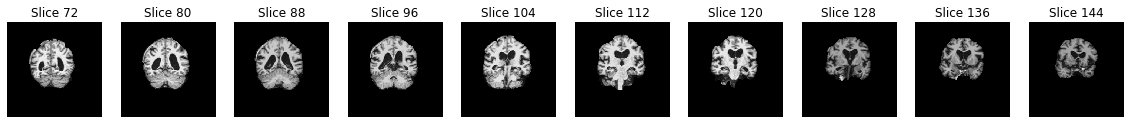

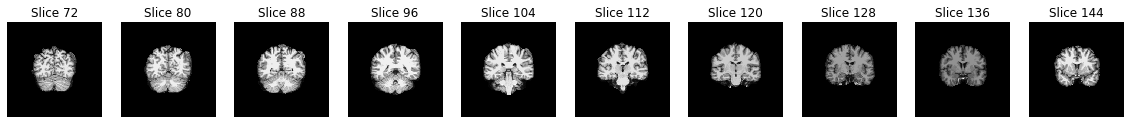

In [8]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i ,:].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

# false CN
show_slices(x_test[8,:,:,:,0])
# correct AD
show_slices(x_test[3,:,:,:,0])
# correct CN
show_slices(x_test[0,:,:,:,0])
